 # Example: Numerical Instability
 
The filtering scheme used in GCM Filters may become unstable and lead to wrong answers when attempting to filter data over a wide range of scales. In this case, there are two options to avoid instability: Using a factored form of the Gaussian filter, or using a combination of GCM filters and data coarsening. 

For the purpose of demonstration, we employ output from a global MOM6 simulation with a spatial resolution of $1/4^{\circ}$ to perform a combination of spatial filtering and coarsening to obtain desired output.

In [1]:
import xarray as xr
import numpy as np
import gcm_filters
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pooch
import warnings

%matplotlib inline

In [2]:
# Function for plotting

def plot_map(ax, da, vmin=-999, vmax=999,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):

    with warnings.catch_warnings(record=True):
        p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                    transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)

        # add separate colorbar
        cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
        cb.ax.tick_params(labelsize=12)

        p.axes.gridlines(color='black', alpha=0.5, linestyle='--')

        _ = plt.title(title, fontsize=14)
        return fig

### Filtering

We filter the vorticity field to $2^{\circ}$ and $10^{\circ}$ resolutions. For this, we first create the filter objects for filtering the data by fixed scale factors of 8 and 40. We then compare the filtered data to the original data. The test data can be found [here](https://figshare.com/articles/dataset/Ocean_Surface_velocities_from_a_global_ocean_simulation/14575356). 

In [3]:
fname = pooch.retrieve(
    url="doi:10.6084/m9.figshare.14575356.v1/Global_U_SSH.nc",
    known_hash="md5:f98b5f2d1f3ccef5685851519481b2da",
);
ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:       (yh: 1080, xq: 1440, yq: 1080, xh: 1440)
Coordinates:
    time          object ...
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables: (12/30)
    ssu           (yh, xq) float32 ...
    ssv           (yq, xh) float32 ...
    zos           (yh, xh) float32 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    ...            ...
    sftof         (yh, xh) float32 ...
    wet           (yh, xh) float32 ...
    wet_c         (yq, xq) float32 ...
    wet_u         (yh, xq) float32 ...
    wet_v         (yq, xh) float32 ...
    zeta          (yq, xq) float32 ...

In [5]:
# Filtering test

area = ds['areacello_bu']
wet_mask = ds['wet_c']

filter_2Deg = gcm_filters.Filter(
    filter_scale=8, dx_min=1, 
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area, 'wet_mask': wet_mask}
)

filter_10Deg = gcm_filters.Filter(
    filter_scale=40, dx_min=1, 
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area, 'wet_mask': wet_mask}
)

zeta_2Deg = filter_2Deg.apply(ds['zeta'], dims=['yq', 'xq'])
%time zeta_2Deg = zeta_2Deg.load()  # trigger filter computation

zeta_10Deg = filter_10Deg.apply(ds['zeta'], dims=['yq', 'xq'])
%time zeta_10Deg = zeta_10Deg.load()  # trigger filter computation

CPU times: user 99 µs, sys: 26 µs, total: 125 µs
Wall time: 128 µs
CPU times: user 93 µs, sys: 24 µs, total: 117 µs
Wall time: 121 µs


CPU times: user 46.2 s, sys: 112 ms, total: 46.3 s
Wall time: 46.3 s


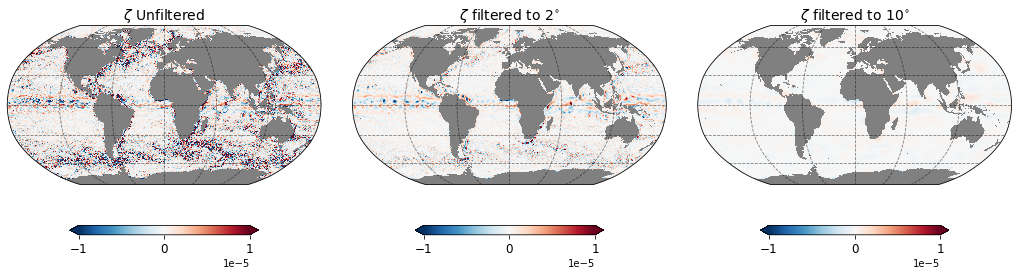

In [6]:
%%time
# plotting
max_z = 1.e-5

grid1 = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,5])

tmp = ds['zeta'].assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ Unfiltered')

tmp = zeta_2Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $2^{\circ}$')

tmp = zeta_10Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 2], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $10^{\circ}$')

### Filtering with Double Precision Data

The simplest way to avoid numerical instability is to enforce computations in double precision. Below, we create dataset `ds_double` from `ds`, and the new dataset `ds_double` has double precision, i.e. `np.float64`. By ensuring computations in double precision, we are able to filter vorticity to $10^{\circ}$ resolution without data coarsening.

In [7]:
ds_double = ds.astype(np.float64)

area_double = ds_double['areacello_bu']
wet_mask_double = ds_double['wet_c']

filter_10Deg_double = gcm_filters.Filter(
    filter_scale=40, dx_min=1, 
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area_double, 'wet_mask': wet_mask_double}
)

zeta_10Deg_double = filter_10Deg_double.apply(ds_double['zeta'], dims=['yq', 'xq'])
%time zeta_10Deg_double = zeta_10Deg_double.load()

CPU times: user 113 µs, sys: 5 µs, total: 118 µs
Wall time: 123 µs


CPU times: user 15.5 s, sys: 83.6 ms, total: 15.5 s
Wall time: 15.5 s


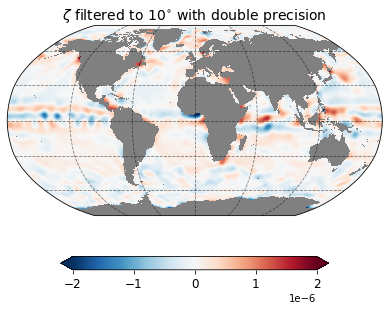

In [8]:
%%time
# plotting
max_z = 0.2e-5

grid1 = plt.GridSpec(1, 1, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[8,5])

tmp = zeta_10Deg_double.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $10^{\circ}$ with double precision')

### Using the Factored Gaussian Filter

Since using double precision doesn't always prevent numerical instability, we continue by presenting two more options to avoid instability, using our single-precision data as an example. The first option only works when using a Gaussian filter. In this case there is an option to apply two or more Gaussian filters sequentially with the final result having the desired scale. The user only needs to input the number of filters and the package automatically determines their scale and then applies them in sequence. In this example, splitting the filter into two pieces still leaves the solution a little grainy, while splitting it into three avoids numerical instability.

In [9]:
filter_10Deg_x2 = gcm_filters.Filter(
    filter_scale=40, dx_min=1, 
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_iterations=2,  # number of constituent filters
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area, 'wet_mask': wet_mask}
)
filter_10Deg_x2

Filter(filter_scale=40, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=32, n_iterations=2, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

In [10]:
filter_10Deg_x3 = gcm_filters.Filter(
    filter_scale=40, dx_min=1, 
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_iterations=3,  # number of constituent filters
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area, 'wet_mask': wet_mask}
)
filter_10Deg_x3

Filter(filter_scale=40, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=26, n_iterations=3, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

In [11]:
zeta_10Deg_x2 = filter_10Deg_x2.apply(ds['zeta'], dims=['yq', 'xq'])
%time zeta_10Deg_x2 = zeta_10Deg_x2.load()

zeta_10Deg_x3 = filter_10Deg_x3.apply(ds['zeta'], dims=['yq', 'xq'])
%time zeta_10Deg_x3 = zeta_10Deg_x3.load()

CPU times: user 116 µs, sys: 5 µs, total: 121 µs
Wall time: 125 µs
CPU times: user 113 µs, sys: 5 µs, total: 118 µs
Wall time: 122 µs


CPU times: user 30.8 s, sys: 87.7 ms, total: 30.9 s
Wall time: 30.9 s


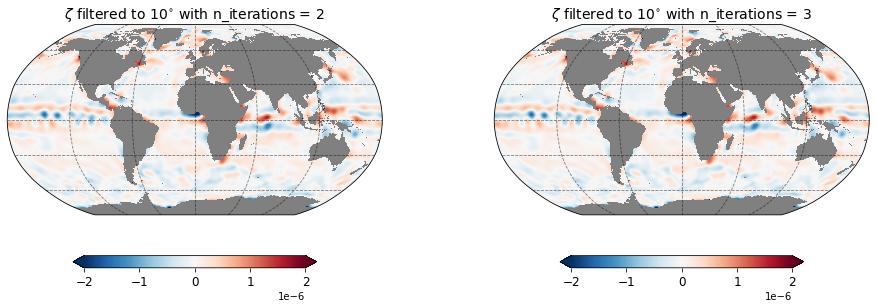

In [12]:
%%time
# plotting
max_z = 0.2e-5

grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[16,5])

tmp = zeta_10Deg_x2.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', 
             title=r'$\zeta$ filtered to $10^{\circ}$ with n_iterations = 2')

tmp = zeta_10Deg_x3.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', 
             title=r'$\zeta$ filtered to $10^{\circ}$ with n_iterations = 3')

### Data Coarsening and Filtering 

If none of the previous options is able to prevent instability, the final option is to filter, coarsen, filter again, then interpolate back to the original resolution. One could simply coarsen, then filter, then interpolate, but the first step (coarsening) risks introducing aliasing errors, where features that have small scale on the $1/4^{\circ}$ appear to be large-scale on the coarsened grid. 

In the example here we first filter the data with a $1^{\circ}$ filter scale. For this initial step, the Taper seems like the most appropriate filter shape because it leaves the large scales more intact than the Gaussian (see  [Filter Theory](https://gcm-filters.readthedocs.io/en/latest/theory.html)). Next we coarsen the filtered data from $1/4^{\circ}$ to $1^{\circ}$, and then filter the coarsened data to $10^{\circ}$ resolution. Finally, we interpolate back to the original $1/4^{\circ}$ resolution.

With this approach, the numerical instability issue does not appear anymore. However, as shown in the last panel, the result is not quite the same as one would obtain in exact arithmetic. The factored Gaussian yields a result essentially identical to that obtained with double precision, while the coarsen/filter/interpolate version yields different results, primarily near the boundary.

In [13]:
# filter with Taper from 1/4 to 1 degree to avoid aliasing
coarsen_fac = 4

filter_1Deg = gcm_filters.Filter(
    filter_scale=coarsen_fac, dx_min=1, 
    filter_shape=gcm_filters.FilterShape.TAPER,
    transition_width=np.pi/2,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area, 'wet_mask': wet_mask}
)

zeta_1Deg = filter_1Deg.apply(ds['zeta'], dims=['yq', 'xq'])
%time zeta_1Deg = zeta_1Deg.load()

CPU times: user 118 µs, sys: 4 µs, total: 122 µs
Wall time: 126 µs


In [14]:
# coarsen filtered data from 1/4 to 1 degree

zeta_coarse = zeta_1Deg.coarsen(xq=coarsen_fac, yq=coarsen_fac, boundary="trim").mean()
area_coarse = ds['areacello_bu'].coarsen(xq=coarsen_fac, yq=coarsen_fac, boundary="trim").sum()
wet_mask_coarse = ds['wet_c'].coarsen(xq=coarsen_fac, yq=coarsen_fac, boundary="trim").max()

In [15]:
# filter coarsened data to 10 degree

filter_10Deg_coarse = gcm_filters.Filter(
    filter_scale=10, dx_min=1, 
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area_coarse, 'wet_mask': wet_mask_coarse}
)

zeta_10Deg_coarse = filter_10Deg_coarse.apply(zeta_coarse, dims=['yq', 'xq'])

%time zeta_10Deg_coarse = zeta_10Deg_coarse.load()  # trigger filter computation

zeta_10Deg_coarse = zeta_10Deg_coarse.interp(xq=ds['xq'], yq=ds['yq'])

CPU times: user 470 µs, sys: 17 µs, total: 487 µs
Wall time: 126 µs


CPU times: user 30.9 s, sys: 93.9 ms, total: 31 s
Wall time: 30.9 s


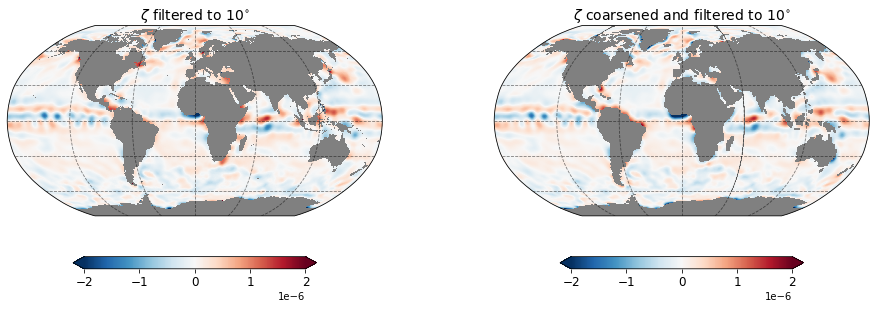

In [16]:
%%time
# plotting
max_z = 0.2e-5

grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[16,5])

tmp = zeta_10Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', 
             title=r'$\zeta$ filtered to $10^{\circ}$')

tmp = zeta_10Deg_coarse.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', 
             title=r'$\zeta$ coarsened and filtered to $10^{\circ}$')

CPU times: user 30.9 s, sys: 84.2 ms, total: 31 s
Wall time: 30.9 s


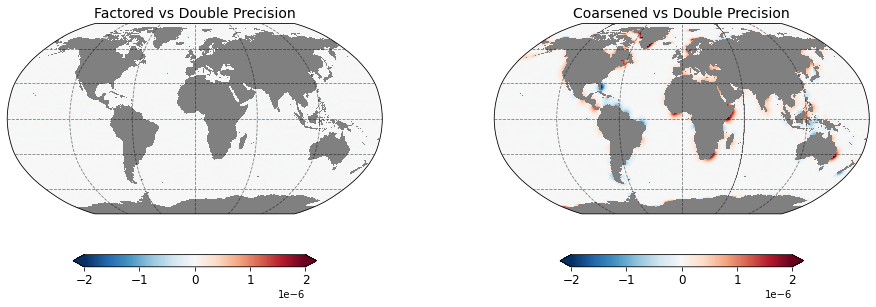

In [17]:
%%time
# plotting the differences
max_z = 0.2e-5

diff_x3 = zeta_10Deg_double - zeta_10Deg_x3
diff_coarse = zeta_10Deg_double - zeta_10Deg_coarse

grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[16,5])

tmp = diff_x3.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', 
             title=r'Factored vs Double Precision')

tmp = diff_coarse.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', 
             title=r'Coarsened vs Double Precision')